In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import joblib

In [15]:
fire_path = "archive (4)/train/wildfire"
nofire_path = "archive (4)/train/nowildfire"

IMG_SIZE = (224, 224)

images = []
labels = []

# Wildfire images
for file in os.listdir(fire_path)[:800]:   # limit for speed
    img = Image.open(os.path.join(fire_path, file)).resize(IMG_SIZE)
    images.append(np.array(img))
    labels.append(1)

# Non-wildfire images
for file in os.listdir(nofire_path)[:800]:
    img = Image.open(os.path.join(nofire_path, file)).resize(IMG_SIZE)
    images.append(np.array(img))
    labels.append(0)

images = np.array(images)
labels = np.array(labels)

print("Total images loaded:", len(images))

Total images loaded: 1600


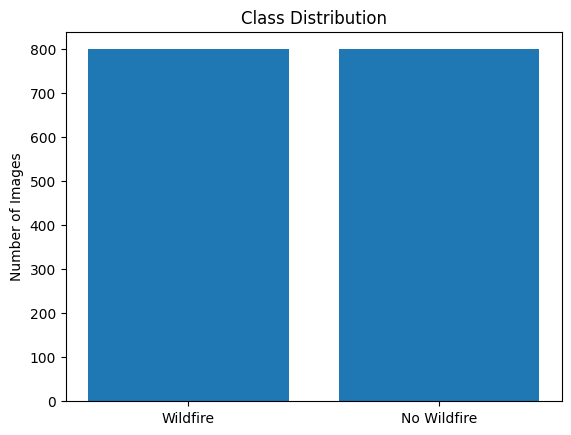

In [16]:
import matplotlib.pyplot as plt

fire_count = sum(labels)
nofire_count = len(labels) - fire_count

plt.bar(["Wildfire", "No Wildfire"], [fire_count, nofire_count])
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.show()

In [25]:
print("Total images:", len(images))
print("Wildfire images:", sum(labels))
print("No wildfire images:", len(labels) - sum(labels))

Total images: 1600
Wildfire images: 800
No wildfire images: 800


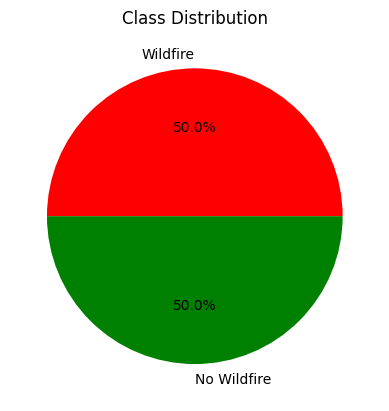

In [26]:
import matplotlib.pyplot as plt

counts = [sum(labels), len(labels) - sum(labels)]

plt.pie(counts,
        labels=["Wildfire", "No Wildfire"],
        autopct='%1.1f%%',
        colors=["red", "green"])

plt.title("Class Distribution")
plt.show()

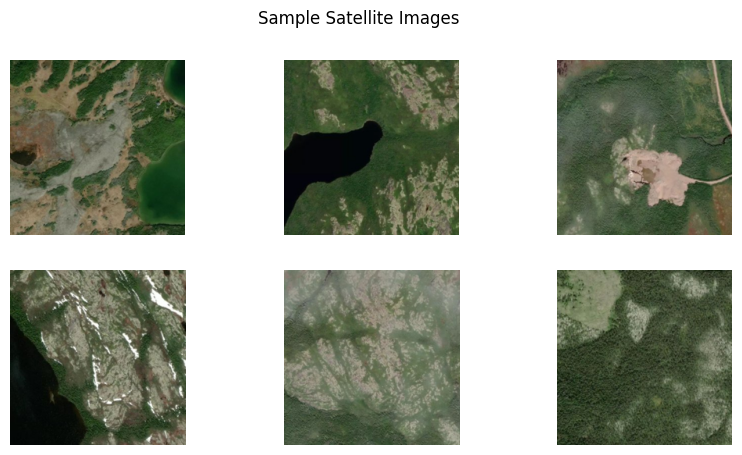

In [17]:
plt.figure(figsize=(10,5))

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i])
    plt.axis("off")

plt.suptitle("Sample Satellite Images")
plt.show()

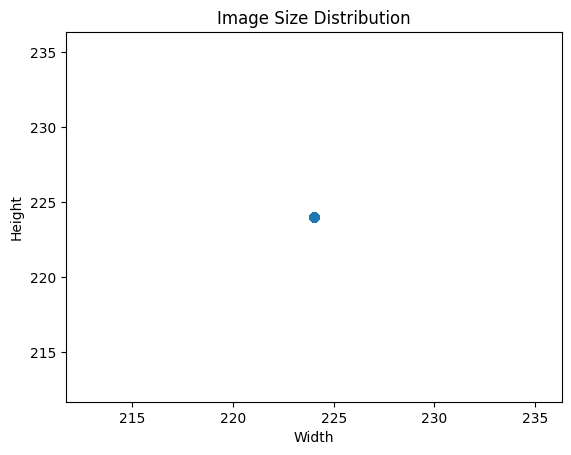

In [28]:
sizes = [img.shape[:2] for img in images]

widths = [s[1] for s in sizes]
heights = [s[0] for s in sizes]

plt.scatter(widths, heights)
plt.title("Image Size Distribution")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

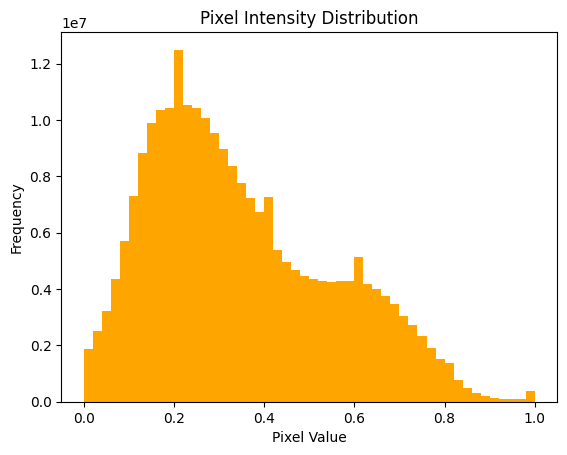

In [29]:
plt.hist(images.flatten(), bins=50, color='orange')
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

In [18]:
images = images / 255.0

In [19]:
import tensorflow as tf

base_model = tf.keras.applications.MobileNetV2(
    weights='imagenet',
    include_top=False,
    pooling='avg',
    input_shape=(224,224,3)
)

features = base_model.predict(images)

print("Feature shape:", features.shape)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 609ms/step
Feature shape: (1600, 1280)


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features, labels,
    test_size=0.2,
    random_state=42
)

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

Training samples: 1280
Testing samples: 320


In [21]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X_train, y_train)

print("Model training complete")

Model training complete


In [22]:
from sklearn.metrics import classification_report, confusion_matrix

pred = model.predict(X_test)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       149
           1       0.99      0.97      0.98       171

    accuracy                           0.98       320
   macro avg       0.98      0.98      0.98       320
weighted avg       0.98      0.98      0.98       320



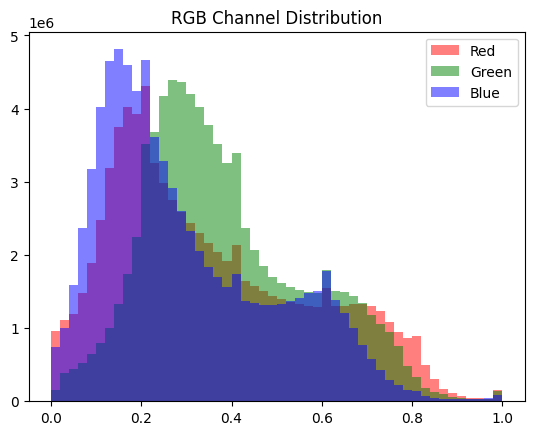

In [32]:
r = images[:,:,:,0].flatten()
g = images[:,:,:,1].flatten()
b = images[:,:,:,2].flatten()

plt.hist(r, bins=50, color='red', alpha=0.5, label='Red')
plt.hist(g, bins=50, color='green', alpha=0.5, label='Green')
plt.hist(b, bins=50, color='blue', alpha=0.5, label='Blue')

plt.legend()
plt.title("RGB Channel Distribution")
plt.show()

In [34]:
def predict_fire(image_path):

    img = Image.open(image_path).convert("RGB")
    img = img.resize((224, 224))

    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Extract features
    features = base_model.predict(img_array)

    # Predict
    prediction = model.predict(features)
    prob = model.predict_proba(features)[0]

    label = "🔥 Wildfire" if prediction[0] == 1 else "🌲 No Wildfire"
    confidence = max(prob) * 100

    # Show image + result
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{label} ({confidence:.2f}% confidence)")
    plt.show()

    print("Prediction:", label)
    print(f"Confidence: {confidence:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


C:\Users\ASUS\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


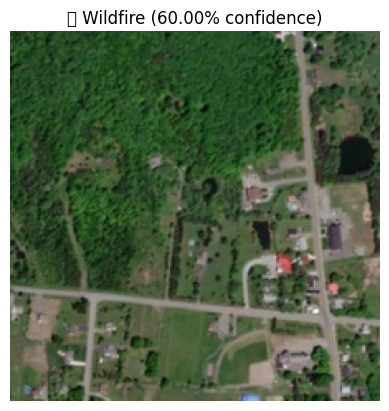

Prediction: 🔥 Wildfire
Confidence: 60.00%


In [36]:
import os
import random

fire_folder = "archive (4)/test/wildfire"
fire_img = random.choice(os.listdir(fire_folder))

predict_fire(os.path.join(fire_folder, fire_img))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


C:\Users\ASUS\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127794 (\N{EVERGREEN TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


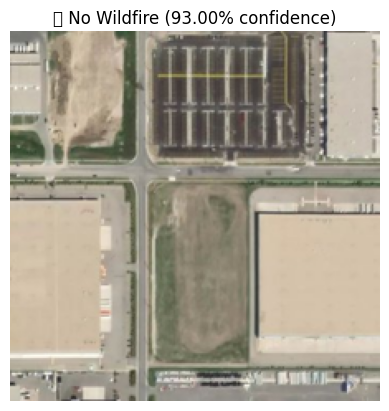

Prediction: 🌲 No Wildfire
Confidence: 93.00%


In [37]:
nofire_folder = "archive (4)/test/nowildfire"
nofire_img = random.choice(os.listdir(nofire_folder))

predict_fire(os.path.join(nofire_folder, nofire_img))

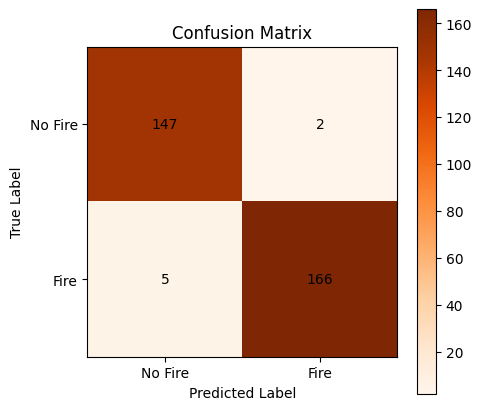

In [38]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, pred)

plt.figure(figsize=(5,5))
plt.imshow(cm, cmap="Oranges")
plt.title("Confusion Matrix")
plt.colorbar()

plt.xticks([0,1], ["No Fire", "Fire"])
plt.yticks([0,1], ["No Fire", "Fire"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center", color="black")

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

probs = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}", color="red")
plt.plot([0,1], [0,1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

NameError: name 'probs' is not defined

In [24]:
import joblib

joblib.dump(model, "wildfire_model.pkl")

print("Model saved as wildfire_model.pkl")

Model saved as wildfire_model.pkl
